# 2D_visualization_TCAE_latent_space

We trained a time prediction model on [Active Matter microscopy videos](https://www.youtube.com/watch?v=aJrB5MMPqhA&ab_channel=ThomsonLab) for 100 epochs (we focused only on isolated microtubule networks organized by polygonal light patterns). See `next_frame_pred_no_arms_01.py`, which is the script containing the training details.

---
In the following notebook, we will project 16 active matter videos into a latent space using the encoder part of our trained TCAE model. We will also use the time embedding learned by our model to perform embedding time-translation in latent space.  In this case, we will use a scalar $\Delta t$ that will take values in `range(0, 20)`.

Given that the dimensionality of the latent space is 2048 dimensions, we will use PCA to project our latent space into a 2D space for visualization.

This notebook reproduces **Figure2**, which can be found in our paper: [Linear Transformations in Autoencoder Latent Space Predict Time Translations in Active Matter System](https://openreview.net/forum?id=ZDBDTHSoMDU).

---

In [1]:
import os
import glob
import numpy as np
from helper_functions import *
from TCAE import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from bokeh.palettes import Category20c_20

experiment_name = "next_frame_pred_no_arms_01"

base_dir = os.path.join(os.getcwd(),experiment_name)
weights_dir = os.path.join(base_dir,'weights')

In [2]:
# Instantiate model
latent_dim = 2048
tcae = TConvAutoEncoder(latent_dim)
# Load weights
# A 'dummy' forward pass is necessary to 'connect' model.
tcae((np.zeros((1,112,112,1), dtype = 'float32'), 
      np.zeros((1,1), dtype = 'float32'))
); 
tcae.load_weights(glob.glob(weights_dir + '/*')[0])

## Using TCAE to perform time-translation in latent space


We will take 16 active matter videos, and for each video, we will take an image at time t, $\textbf{X}_t$ and map it to its corresponding embedding $\textbf{z}_t$.

$$\mathbf{X}_t \mapsto \mathbf{z}_t$$

Then we will take the learned time embedding called $\boldsymbol{\phi}$ and scale it using $\Delta t$ in {0,1,...,20}. 

Lastly, we will translate all $\mathbf{z}_t$ by $\Delta t \boldsymbol{\phi}$

$$\mathbf{z}_t \mapsto (\mathbf{z}_t + \Delta t \boldsymbol{\phi}) $$

In [3]:
# Let's load all Active Matter video data
file_list = glob.glob("/home/ubuntu/am-cvae/data/112x112_pulse/*")
file_list.sort()

start_frame = 30
end_frame = 200
file_shape = [360, 112, 112]
n_frame = 20 # dt max value is 20
video_length = abs(start_frame - end_frame)
positions_pred = video_length - n_frame
n_points = n_frame * positions_pred # number of embeddings per experiment

data = load_list_files_as_array(
    file_list, 
    file_shape,
    start_index = start_frame, 
    end_index = end_frame
)
data = np.expand_dims(data, -1)
x_all, _, dt_all = timeshift_dataset(data, n_frame=n_frame , video_length= video_length)
color_list = list(reversed(Category20c_20[:16]))

100%|██████████| 16/16 [00:00<00:00, 39.92it/s]


In [4]:
# Xt -> zt, Images in AM video to image embeddings
image_embeddings = tcae.encoder.predict(x_all) 
# Φ -> ΔtΦ, Scaling time embedding by Δt
time_embeddings = tcae.time_embedding.predict(dt_all) 
# zt -> (zt + ΔtΦ), Time-translation in latent space
translated_embeddings = image_embeddings + time_embeddings 

## Using PCA to visualize translated embeddings.

In [5]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(translated_embeddings)

We will project TCAE embeddings to 2dimensional space for visualization using PCA:

$$\text{PCA}: \mathbb{R}^{2048} \mapsto \mathbb{R}^{2}$$

## Plotting PCA results:

First, we will create a nested dictionary that will help us to access properties we assign to each experiment:

The experiment's properties are"

- "color" -> Color used to plot the given experiment
- "idx_a" -> List of indices to access the experiment's embeddings (**panel a**)
- "idx_b" -> List of indices to access the experiment's embeddings (**panel b**)
- "subplot" -> Row and column assigned to the experiment geometry (**panel b**)

*Note: Panel C and D use the same indices as Panel A* 

In [6]:
props = {}
for i, (file, color) in enumerate(zip(file_list, color_list)):
    # Find experiment name substr in file name
    label = file[file.find("pulse/")+len("pulse/"):].split("_")[0]
    props[label] = {}
    # Assign a color to each geometry
    props[label]["color"] = color
    # Indices for slicing `embeddings_2d` vary between panels A and B
    props[label]["idx_a"] = slice(n_points*i,n_points*(i+1))
    props[label]["idx_b"] = [(n_points*i) + (n_frame*j) for j in range(positions_pred)]
    # Assing row and column to each geometry in panel B
    props[label]["subplot"] = {'cir': [0,0], 'hex': [0,1], 'rec': [1,0], 'tri' : [1,1]}[label[:3]]

### Figure 2A)
Embeddings of all the images in the dataset and their corresponding translations using a ∆t from 0 to 20, colored by light pattern.

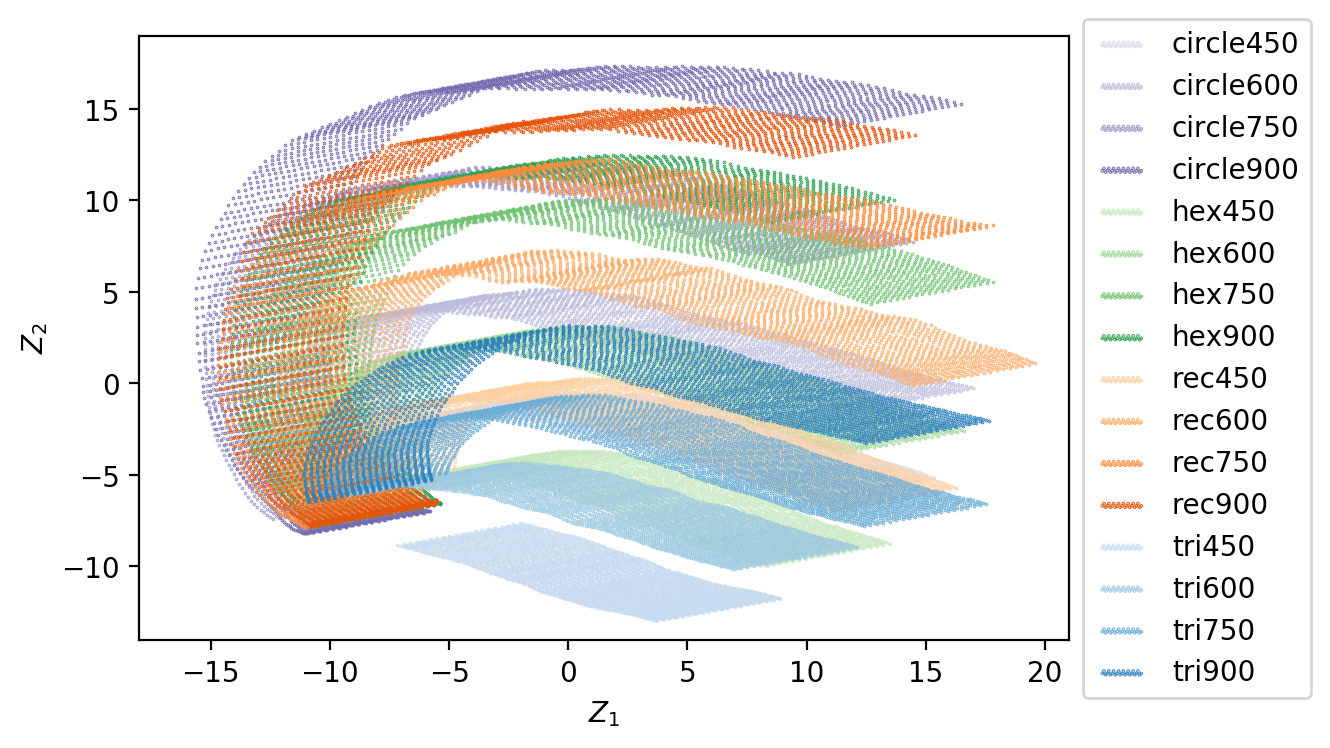

In [7]:
plt.figure(dpi = 200)
for exp in props.keys():
    plt.scatter(
        embeddings_2d[props[exp]["idx_a"]][:,0], 
        embeddings_2d[props[exp]["idx_a"]][:,1],
        label = exp,
        c = props[exp]["color"],
        s = .1,
    )
plt.xlabel("$Z_{1}$")
plt.ylabel("$Z_{2}$")
plt.ylim(-14,19)
plt.xlim(-18,21)
plt.legend(bbox_to_anchor=(1.0, 1.05) , scatterpoints=25, fontsize=10);

### Figure 2B)

Embeddings without translations grouped by geometry. The dashed line in the lower left subplot is the video held out for validation (rec600).

<Figure size 1200x800 with 0 Axes>

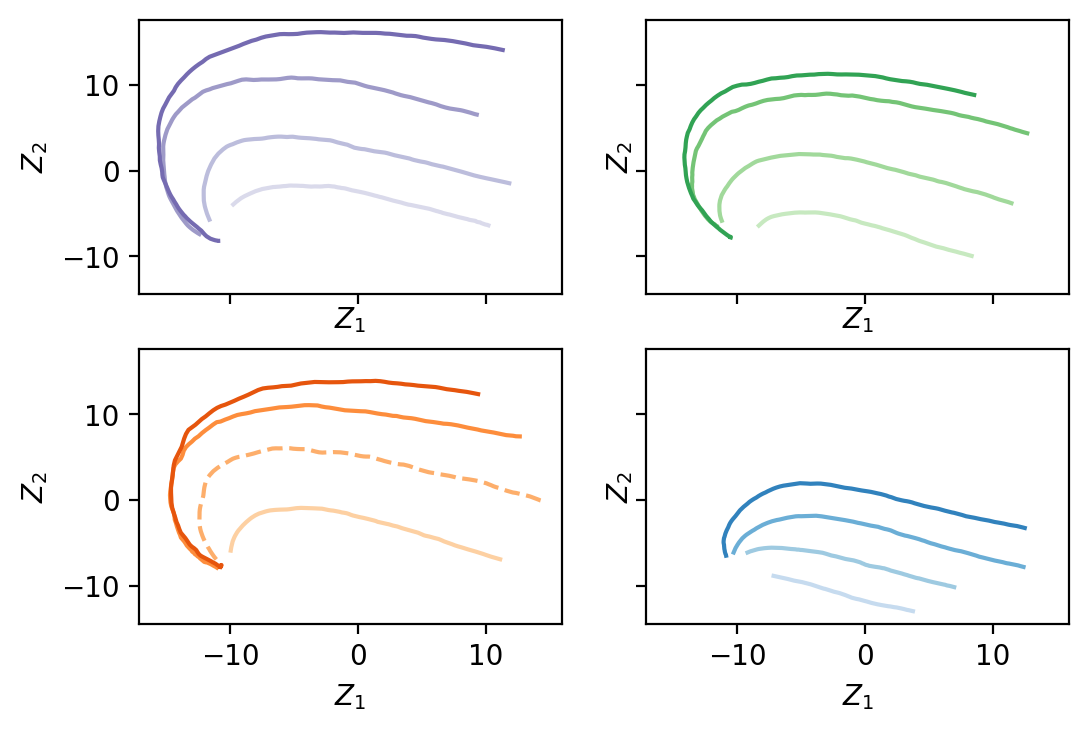

In [8]:
plt.figure(dpi = 200)
fig, axs = plt.subplots(2, 2, dpi = 200, sharex=True, sharey=True)
for exp in props.keys():
    column, row = props[exp]["subplot"]
    if 'rec600' in exp:
        ls = '--'
    else:
        ls = '-'
    axs[column, row].plot(
        embeddings_2d[props[exp]["idx_b"]][:,0], 
        embeddings_2d[props[exp]["idx_b"]][:,1],
        label = exp,
        c = props[exp]["color"],
        linestyle = ls,
    )
for ax in fig.get_axes():
    ax.set(xlabel='$Z_{1}$', ylabel='$Z_{2}$')

### Figure 2C)

Embeddings of triangular geometries and their translations colored by ∆t.

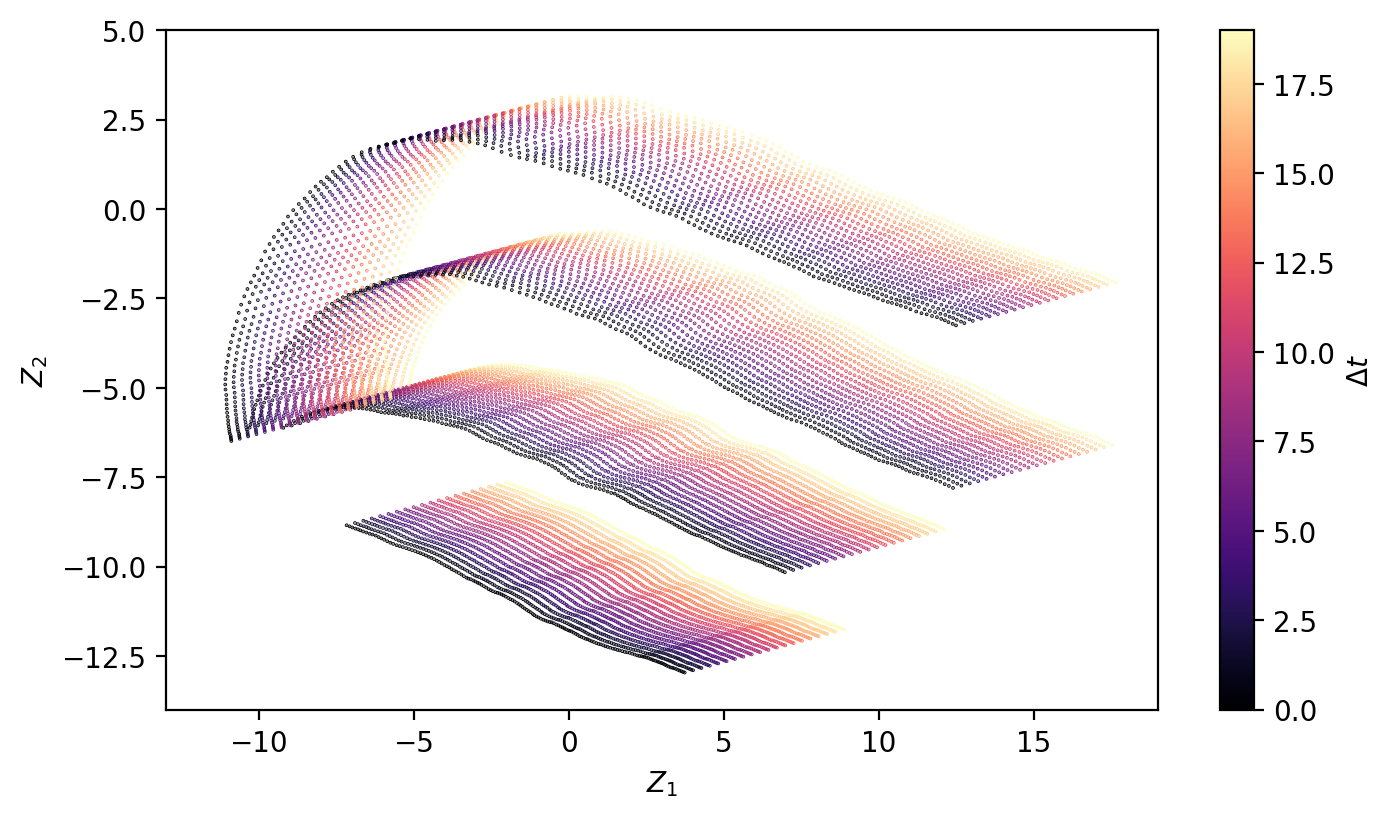

In [9]:
plt.figure(dpi = 200, figsize = (8,4.5))
for exp in props.keys():
    if 'tri' in exp: # Select only triangle cases
        plt.scatter(
            embeddings_2d[props[exp]["idx_a"]][:,0], 
            embeddings_2d[props[exp]["idx_a"]][:,1],
            c = dt_all[0:n_points].flatten(),
            s = .1,
            cmap="magma",
        )
plt.xlabel("$Z_{1}$")
plt.ylabel("$Z_{2}$")
plt.ylim(-14,5)
plt.xlim(-13,19)
cbar = plt.colorbar();
cbar.set_label(r'$\Delta t$')

### Figure 2D)

Embeddings of triangular geometries and their translations colored by physical time.

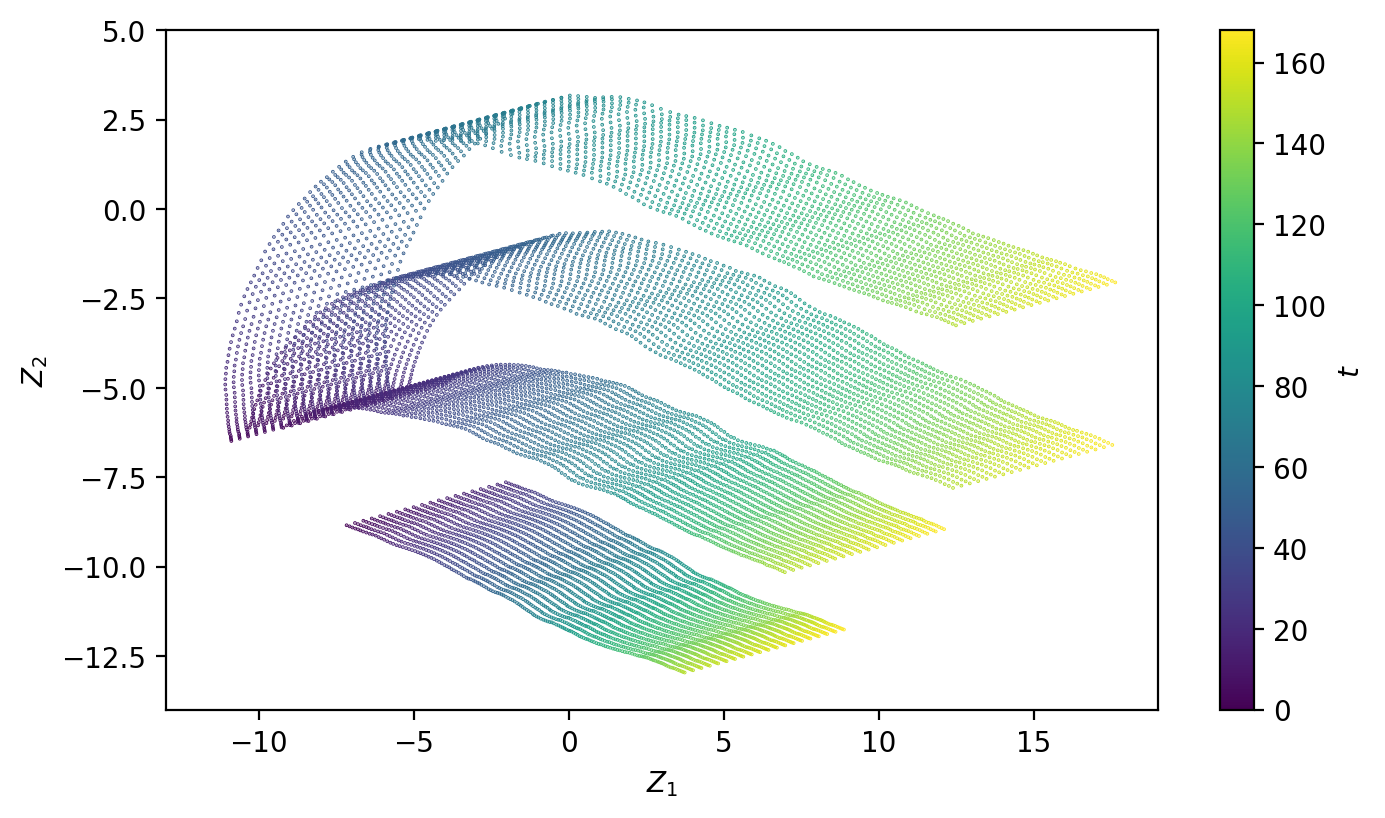

In [10]:
plt.figure(dpi = 200, figsize = (8,4.5))
t = np.array(
        [init_pos+dt for init_pos in range(positions_pred) for dt in range(n_frame)]
    )
for exp in props.keys():
    if 'tri' in exp: # Select only triangle cases
        plt.scatter(
            embeddings_2d[props[exp]["idx_a"]][:,0], 
            embeddings_2d[props[exp]["idx_a"]][:,1],
            c = t,
            s = .1,
            cmap="viridis",
        )
plt.xlabel("$Z_{1}$")
plt.ylabel("$Z_{2}$")
plt.ylim(-14,5)
plt.xlim(-13,19)
cbar = plt.colorbar();
cbar.set_label(r'$t$')